<a href="https://colab.research.google.com/github/tyler55792/Differentiable-optimization-layers-in-PyTorch/blob/main/cvxpylayers_implementaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install cvxpylayers

In [ ]:
import numpy as np
import numpy.random as npr

import torch
from torch import nn
import torch.nn.functional as F

import os
import sys
import shutil

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
plt.style.use('bmh')
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer


The water-filling problem is used to determine optimal power allocation for a multidimensional communication channel and is pictured below. θ<sub>d</sub>, ω<sub>d</sub>, and ω<sub>D+1</sub> are learnable parameters, u<sub>d</sub> is the input into the layer, x<sub>d</sub> is the optimization variable, and D is the dimension of the problem.

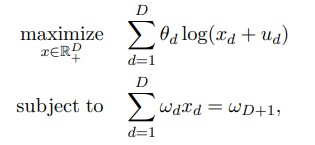

First we implement this optimization problem using cvxpy

In [ ]:
D = 50

theta = cp.Parameter(D, pos = True)
omega = cp.Parameter(D, pos = True)
w1 = cp.Parameter(1)
u = cp.Parameter(D)

x = cp.Variable(D, pos = True)
x_plus_u = cp.Variable(D)   # in the objective function, cp.log(_x + _u) must be parameter free in order to be affine under DPP

obj = cp.Maximize(cp.sum(theta @ cp.log(x_plus_u)))
cons = [cp.sum(omega @ x) == w1, x_plus_u == x + u, x >= 0]
prob = cp.Problem(obj, cons)

layer_truth = CvxpyLayer(prob, parameters=[theta, omega, w1, u], variables=[x])


Then we randomly generate an instance of the optimization problem by creating arbitrary vectors θ<sub>d</sub> (theta), ω<sub>d</sub> (omega), and ω<sub>D+1</sub> (w1) as the ground truth parameters. This ground truth instance will then be used to generate the training data.

In [ ]:
theta = torch.FloatTensor(np.random.uniform(low=1.0, high=1.1, size=D))
omega = torch.FloatTensor(np.random.uniform(low=1.0, high=1.1, size=D))
w1 = torch.FloatTensor(np.random.uniform(low=1.0, high=1.1, size=1))

Cvxpylayers is then used to fit a qudratic program (QP) to the water filling program. To do this, the QP will first be implemented in CVXPY.

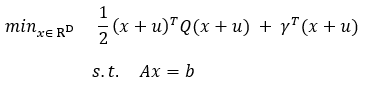

In [ ]:
ncon = 1

u = cp.Parameter(D)
gamma_hat = cp.Parameter(D)
A_hat = cp.Parameter([ncon,D])
b_hat = cp.Parameter(ncon)

x_hat = cp.Variable(D)
x_plus_u_hat = cp.Variable(D)

Q_sqrt_hat = cp.Parameter([D,D], symmetric=True)

obj_fit = cp.Minimize((1/2)*cp.sum_squares(Q_sqrt_hat @ x_plus_u_hat) + gamma_hat @ x_plus_u_hat)
cons_fit = [A_hat @ x == b_hat, x_plus_u_hat == x_hat + u, x_hat >= 0]
prob_fit = cp.Problem(obj_fit, cons_fit)

layer_fit = CvxpyLayer(prob_fit, parameters=[u, gamma_hat, A_hat, b_hat, Q_sqrt_hat], variables=[x_hat])

Next, we initialize new parameters for our learning problem.

In [ ]:
import scipy.linalg

gamma_hat = nn.Parameter(torch.FloatTensor(np.random.uniform(low=1.0, high=1.1, size=D)))
A_hat = nn.Parameter(torch.FloatTensor(np.random.uniform(low=1.0, high=1.1, size=(ncon,D))))

z0 = torch.full([D], 0.17)
s0 = torch.full([ncon], 0.17)
b_hat = A_hat.mv(z0)+s0

L = np.random.uniform(low=1.0, high=1.1, size=(D,D))
Q = L.T @ L
Q_sqrt_hat = nn.Parameter(torch.FloatTensor(scipy.linalg.sqrtm(Q)))

Then we learn parameters of the quadratic program using Cvxpylayers. For each iteration, we generate a random input u and then solve the ground truth optimization problem for the output x. Then we solve the learning problem for its output x_hat and differentiate the output with respect to its parameters and use this for learning.

In [ ]:
opt = torch.optim.Adam([gamma_hat, A_hat, Q_sqrt_hat], lr=100)
losses = []

for i in range(1000):
  u = torch.FloatTensor(np.random.uniform(low=1.0, high=2.0, size=D))
  x, = layer_truth(theta, omega, w1, u)

  b_hat = A_hat.mv(z0)+s0
  x_hat, = layer_fit(u, gamma_hat, A_hat, b_hat, Q_sqrt_hat)
  loss = (x_hat-x).norm()
  losses.append(loss)

  opt.zero_grad()
  loss.backward()
  opt.step()

Plot loss vs iteration

(0.0, 100.63450353050231)

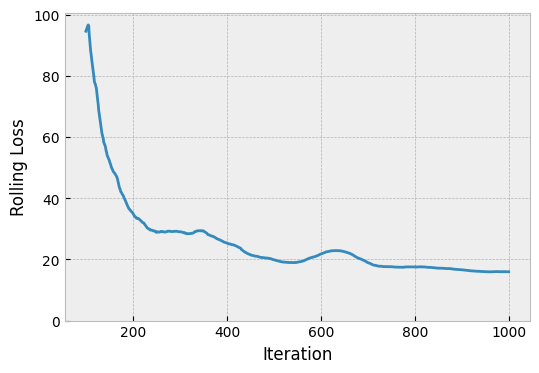

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
N = 100
xs = np.arange(N-1, len(losses))
ys = np.convolve(torch.tensor(losses).detach().numpy(), np.full(N, 1./N), mode='valid')

ax.plot(xs, ys)
ax.set_xlabel('Iteration')
ax.set_ylabel('Rolling Loss')
ax.set_ylim(0, None)


The rolling loss is represented as the Euclidean norm (L2 norm) of the difference vector between the cvxpylayers learning problem and the ground-truth solution. The decrease of the rolling loss over iterations represents the learning of the parameters within the optimization problem and convergence to a reasonable solution. With the parameters of the cvxpylayers optimization layer now learned, they are then evaluated using test input/output cases generated from the ground truth model.

In [ ]:
numPoints = 300
sumLoss = 0

for i in range(numPoints):
  u = torch.FloatTensor(np.random.uniform(low=1.0, high=2.0, size=D))
  x, = layer_truth(theta, omega, w1, u)
  x_hat, = layer_fit(u, gamma_hat, A_hat, b_hat, Q_sqrt_hat)

  sumLoss += (x_hat-x).norm(1)

#loss norm average
print(sumLoss/numPoints)

tensor(68.8639, grad_fn=<DivBackward0>)


The test cases demonstrate that cvxpylayers successfully solved the water-filling optimization problem with a L1 loss norm of 68.86. Future work with this project should explore the use of alternative objective functions in the learning problem. Improvements over the quadratic objective function could lead to a better fitting solution.